# Generating Cartoon faces with GANs
* What is GANs

A generative adversarial network (GAN) is a machine learning (ML) model in which two neural networks compete with each other by using deep learning methods to become more accurate in their predictions.
* What is deep learning network. [Source](https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/)

A deep neural network (DNN) is an artificial neural network (ANN) with multiple layers between the input and output layers. [Source](https://www.bmc.com/blogs/deep-neural-network/)

For this notebook we will use two neural networks: a Generator and a Discriminator. The generator generates a "fake" sample given a random vector/matrix, and the discriminator attempts to detect whether a given sample is "real" (picked from the training data) or "fake" (generated by the generator). Training happens in tandem: we train the discriminator for a few epochs, then train the generator for a few epochs, and repeat. This way both the generator and the discriminator get better at doing their jobs.  [Source](https://jovian.com/aakashns/06b-anime-dcgan)

We'll use the [Google's Cartoon Dataset](https://www.kaggle.com/datasets/brendanartley/cartoon-faces-googles-cartoon-set/code), which is a collection of random, 2D cartoon avatar images. The cartoons vary in 10 artwork categories, 4 color categories, and 4 proportion categories, with a total of ~1013 possible combinations.

In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/brendanartley/cartoon-faces-googles-cartoon-set'
od.download(dataset_url)

100%|██████████| 2.34G/2.34G [00:22<00:00, 114MB/s]


In [3]:
from IPython.display import Image
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torchvision.transforms as tt
from tqdm.notebook import tqdm
from torch.utils.data import random_split
from torchvision.utils import make_grid

%matplotlib inline

The dataset has a single folder called `images` which contains all 1,000,000+ images in JPG format. Each image is 500x500 pixels.

In [4]:
Data_Dir = '/content/cartoon-faces-googles-cartoon-set'
print(os.listdir(Data_Dir))

['cartoonset100k_jpg']


In [5]:
image_size = 100
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [6]:
train_ds = ImageFolder(Data_Dir, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

In [7]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True) 

Let's create helper functions to denormalize the image tensors and display some sample images from a training batch.

In [8]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [9]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

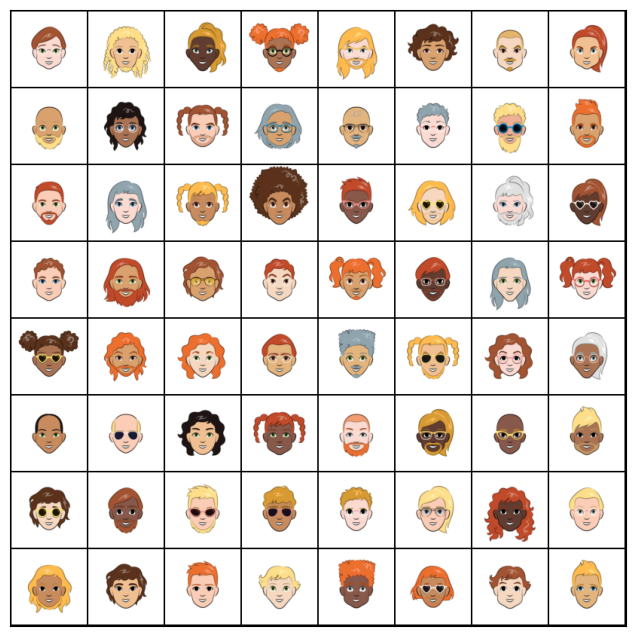

In [10]:
show_batch(train_dl)

## Using a GPU

To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU, if one is available.

In [11]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [12]:
device = get_default_device()
device

device(type='cuda')

We can now move our training data loader using DeviceDataLoader for automatically transferring batches of data to the GPU (if available).

In [13]:
train_dl = DeviceDataLoader(train_dl, device)

## Discriminator Network

The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network. We'll use a convolutional neural networks (CNN) which outputs a single number output for every image. We'll use stride of 2 to progressively reduce the size of the output feature map.

[Source1](https://developers.google.com/machine-learning/gan/discriminator)

[Source2](https://sthalles.github.io/advanced_gans/)

[Source3](https://www.baeldung.com/cs/gan-loss)

In [14]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [15]:
discriminator = to_device(discriminator, device)

## Generator Network

The input to the generator is typically a vector or a matrix of random numbers (referred to as a latent tensor) which is used as a seed for generating an image. The generator will convert a latent tensor of shape (128, 1, 1) into an image tensor of shape 3 x 28 x 28. To achive this, we'll use the ConvTranspose2d layer from PyTorch, which is performs to as a transposed convolution (also referred to as a deconvolution)

[Source1](https://developers.google.com/machine-learning/gan/generator)

[Source2](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md#transposed-convolution-animations)

[Source3](https://stackoverflow.com/questions/41489907/generative-adversarial-networks-tanh)

In [16]:
latent_size = 128

In [17]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

Let's generate some outputs using the generator and view them as images by transforming and denormalizing the output.

torch.Size([128, 3, 64, 64]) ;


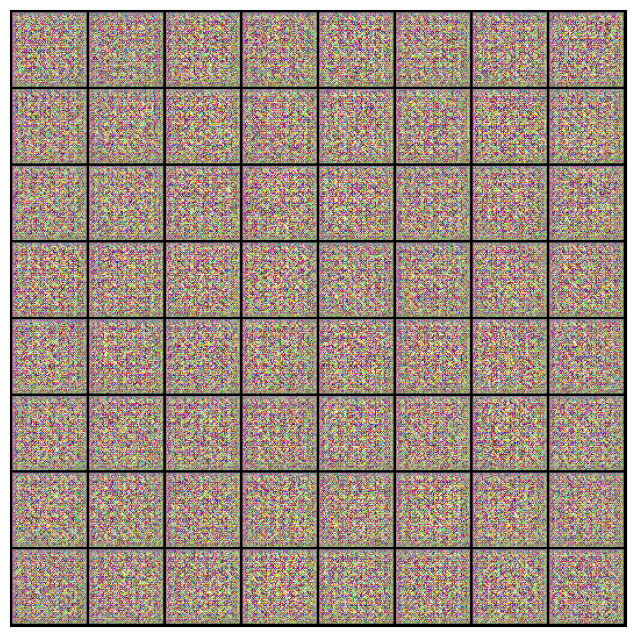

In [18]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape,';')
show_images(fake_images)

In [19]:
generator = to_device(generator, device)

## Discriminator Training

Since the discriminator is a binary classification model, we can use the binary cross entropy loss function to quantify how well it is able to differentiate between real and generated images.

Here are the steps involved in training the discriminator.

* We expect the discriminator to output 1 if the image was picked from the real MNIST dataset, and 0 if it was generated using the generator network.

* We first pass a batch of real images, and compute the loss, setting the target labels to 1.

* Then we pass a batch of fake images (generated using the generator) pass them into the discriminator, and compute the loss, setting the target labels to 0.

* Finally we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator.

[Learn more](https://datascience.stackexchange.com/questions/55121/how-discriminator-knows-if-the-image-is-real-or-fake-at-the-initial-phase)

In [20]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 9, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

## Generator Training

Since the outputs of the generator are images, it's not obvious how we can train the generator. This is where we employ a rather elegant trick, which is to use the discriminator as a part of the loss function. Here's how it works:

* We generate a batch of images using the generator, pass the into the discriminator.

* We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator.

* We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images to "fool" the discriminator.

In [21]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

Let's create a directory where we can save intermediate outputs from the generator to visually inspect the progress of the model. We'll also create a helper function to export the generated images.

In [22]:
sample_dir = 'gan_generated'
os.makedirs(sample_dir, exist_ok=True)

In [23]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model. Let's save one set of images before we start training our model.

In [24]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


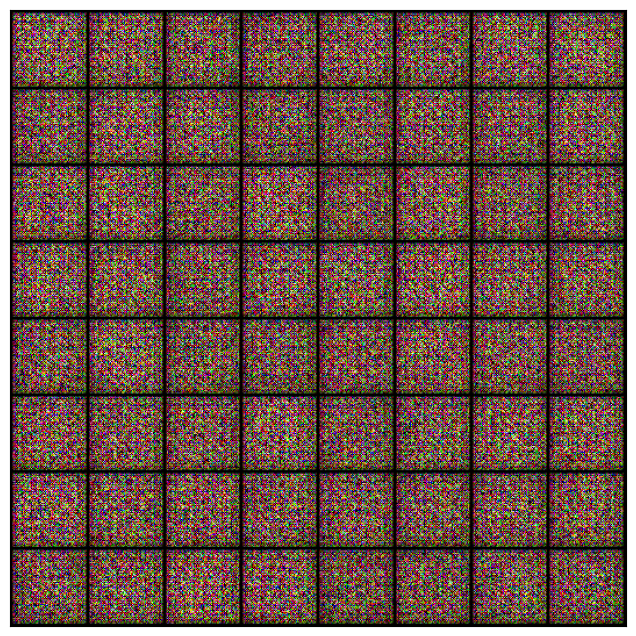

In [25]:
save_samples(0, fixed_latent)

## Full Training Loop

Let's define a fit function to train the discriminator and generator in tandem for each batch of training data. We'll use the Adam optimizer with some custom parameters (betas) that are known to work well for GANs. We will also save some sample generated images at regular intervals for inspection.

In [26]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

We are now ready to train the model. Try different learning rates to see if you can maintain the fine balance between the training the generator and the discriminator.

In [ ]:
lr = 0.0006
epochs = 25

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 10.2746, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0001.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 11.5063, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0002.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 12.5455, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0003.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 13.0938, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0004.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 13.3825, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0005.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 14.4179, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0006.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 15.2446, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0007.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 15.6755, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0008.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 16.2917, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0009.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 16.7186, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0010.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 17.2876, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0011.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 17.3756, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0012.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 17.2649, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0013.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 17.7001, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0014.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 18.2607, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0015.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 18.2200, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0016.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 18.5785, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0017.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 19.4352, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0018.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 20.0740, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0019.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 20.3421, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0020.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 20.4152, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0021.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 20.8207, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0022.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 20.9457, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0023.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 21.6031, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0024.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 22.2654, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0025.png


## Save and Commit

We can upload the full snapshot of this experiment to Jovian:

* Jupyter notebook
* Hyperparameters & metrics
* Models weights
* Training video

In [ ]:
!pip install jovian --quiet --upgrade
import jovian

In [ ]:
jovian.reset()
jovian.log_hyperparams(lr=lr, epochs=epochs)

In [ ]:
jovian.log_hyperparams(lr=lr1, epochs=epochs1)

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
jovian.log_metrics(loss_g=losses_g[-1], 
                   loss_d=losses_d[-1], 
                   real_score=real_scores[-1], 
                   fake_score=fake_scores[-1])

In [ ]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

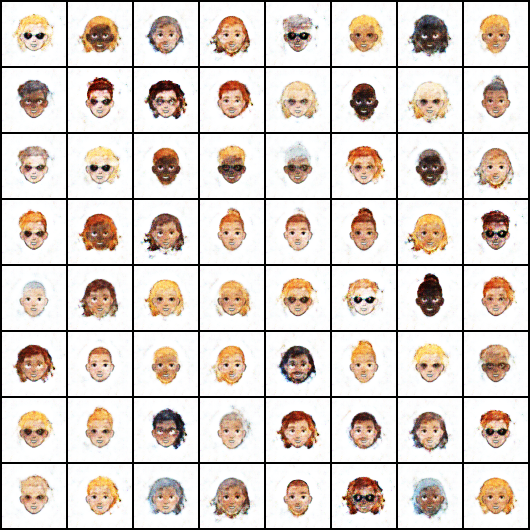

In [27]:
Image('./generated/generated-images-0001.png')

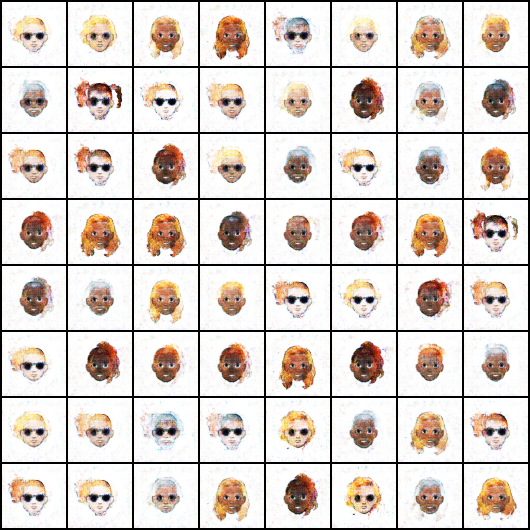

In [29]:
Image('/content/generated/generated-images-0005.png')

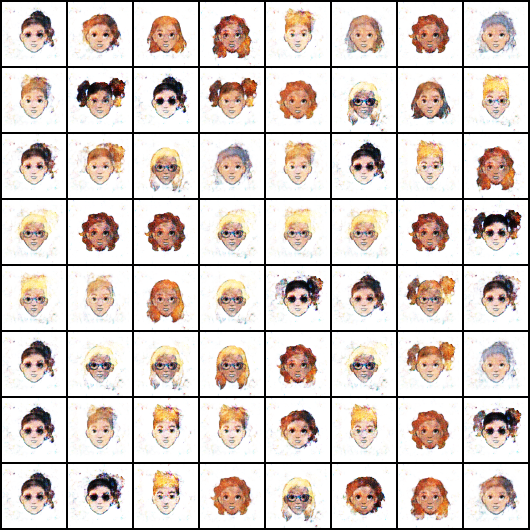

In [30]:
Image('/content/generated/generated-images-0010.png')

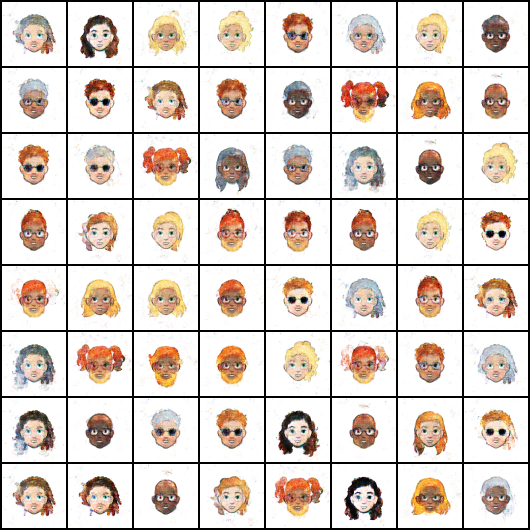

In [31]:
Image('/content/generated/generated-images-0017.png')

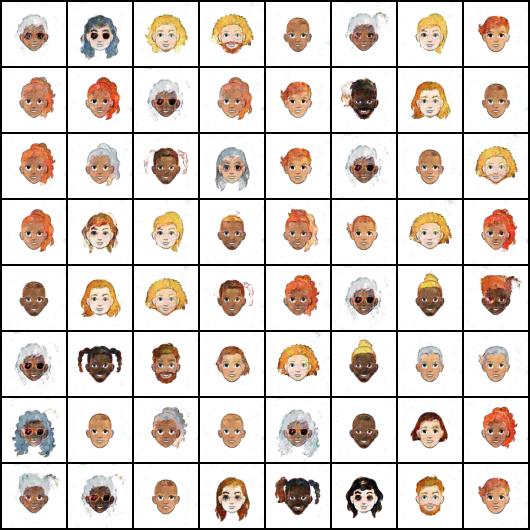

In [32]:
Image('/content/generated/generated-images-0025.png')

## Summary
From the last image filke we can see that we have been able to generated cartoon faces using GANS. You should try playing around with hyperparameters like batch_size, image_size, leakyReLu and Relu layers and see the effect it has on the final generated files

## Future Works
From our source material we can see that the google cartoon faces have varoius skin tones, facial features and accessories. We should focusing on one of these like see if we can generate faces with specific facial features and accessories.